In [3]:
# PROBE_CHARACTERISATION.IPYNB - A showcase of how the CBC probe module can be characterised using constitutive reporters
# By Kirill Sechkar

In [4]:
# PACKAGE IMPORTS

import numpy as np
import jax
import jax.numpy as jnp
import functools
import pandas as pd
from bokeh import plotting as bkplot, models as bkmodels, layouts as bklayouts, io as bkio
from bokeh.colors import RGB as bkRGB
import matplotlib as mpl, matplotlib.pyplot as plt


import time

# CIRCUIT AND EXTERNAL INPUT IMPORTS
from sim_tools.cell_model import *
import sim_tools.cell_genetic_modules as gms
import sim_tools.controllers as ctrls
import sim_tools.reference_switchers as refsws
import sim_tools.ode_solvers as odesols
from probe_char_tools import *

# set up jax
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

# set up bokeh
bkio.reset_output()
bkplot.output_notebook()

# set up matplotlib
%matplotlib widget

locale: Cannot set LC_CTYPE to default locale: No such file or directory
locale: Cannot set LC_MESSAGES to default locale: No such file or directory
locale: Cannot set LC_COLLATE to default locale: No such file or directory


Loading BokehJS ...

In [5]:
# PART 1: CHARACTERISE CONSTITUTIVE REPORTERS

# DEFINE CONSTITUTIVE REPORTER PARAMETERS
# for simplicity, just consider different promoter strengths for same copy numbers and RBSs
# assuming protein maturation rates known (andidentical for simplicity)

# default parameteres for all constitutive reporters
constrep_default_par={}
constrep_default_par['func_'] = 1.0  # gene functionality - 1 if working, 0 if mutated
constrep_default_par['c_'] = 10.0  # copy no. (nM)
constrep_default_par['a_'] = 100.0  # promoter strength (unitless)
constrep_default_par['b_'] = 6.0  # mRNA decay rate (/h)
constrep_default_par['k+_'] = 60.0  # ribosome binding rate (/h/nM)
constrep_default_par['k-_'] = 60.0  # ribosome unbinding rate (/h)
constrep_default_par['n_'] = 300.0  # protein length (aa)
constrep_default_par['d_'] = 0.0  # rate of active protein degradation by synthetic protease - zero by default (/h/nM)
# default maturation rate
constrep_default_par['mu_ofp2']=1/(13.6/60)   # sfGFP maturation time of 13.6 min

# define promoter strengths considered
# feasible range between 40 and 2500 (Sechkar et al., Nature Comms 2024) - but also may have higher plasmid copy numbers
# you don't have to, but order of increasing magnitudes will make things look neat
constrep_as=list(np.linspace(40,25000,3))
# constrep_as=list(np.logspace(np.log10(40),np.log10(25000),5))

# define maturation rates considered
constrep_mus = [1/(13.6/60)]*len(constrep_as)  # sfGFP maturation time of 13.6 min

# define reporter pairs to consider - assume all reporters characterised in a pair with the first one
constrep_pairs = []
for i in range(1,len(constrep_as)):
    constrep_pairs.append((0,i))

In [6]:
# SET SIMULATION AND CONTROLLER PARAMETERS

# set controller parameters - irrelevant for the constitutive reporter characterisation
refs = jnp.array([0.0])
control_delay = 0  # control action delay
u0 = 0.0  # initial control action

 # set simulation parameters
tf = (0.0, 48.0)  # simulation time frame - assuming the steady state is reached in 50 hours

# measurement time step
meastimestep = 48.0  # hours - we only care about the steady state at the end

# choose Euler integration timestep
euler_timestep = 1e-5  # hours

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [7]:
# INITIALISE AND PARAMETERISE THE CELL MODEL AND ODE SOLVER

# initialise cell model
model_auxil = ModelAuxiliary()  # auxiliary tools for simulating the model and plotting simulation outcomes
model_par = model_auxil.default_params()  # get default parameter values
init_conds = model_auxil.default_init_conds(model_par)  # get default initial conditions

# add reference tracker switcher
model_par_with_refswitch, ref_switcher = model_auxil.add_reference_switcher(model_par,  # cell model parameters
                                                                                    refsws.no_switching_initialise, # function initialising the reference switcher (none here)
                                                                                    refsws.no_switching_switch  # function switching the references to be tracked (none here)
                                                                                    )

# load synthetic genetic modules and the controller
odeuus_complete, \
    module1_F_calc, module2_F_calc, \
    module1_specterms, module2_specterms, \
    controller_action, controller_update, \
    par, init_conds, controller_memo0, \
    synth_genes_total_and_each, synth_miscs_total_and_each, \
    controller_memos, controller_dynvars, controller_ctrledvar, \
    modules_name2pos, modules_styles, controller_name2pos, controller_styles, \
    module1_v_with_F_calc, module2_v_with_F_calc = model_auxil.add_modules_and_controller(
        # module 1 - one constitutive reporter
        gms.constfp_initialise,  # function initialising the circuit
        gms.constfp_ode,  # function defining the circuit ODEs
        gms.constfp_F_calc, # function calculating the circuit genes' transcription regulation functions
        gms.constfp_specterms, # function calculating the circuit genes effective mRNA levels (due to possible co-expression from the same operons)
        # module 2 - another constitutive reporter
        gms.constfp2_initialise,  # function initialising the circuit
        gms.constfp2_ode,  # function defining the circuit ODEs
        gms.constfp2_F_calc, # function calculating the circuit genes' transcription regulation functions
        gms.constfp2_specterms, # function calculating the circuit genes effective mRNA levels (due to possible co-expression from the same operons)
        # controller
        ctrls.cci_initialise,  # function initialising the controller
        ctrls.cci_action,  # function calculating the controller action
        ctrls.cci_ode,  # function defining the controller ODEs
        ctrls.cci_update,  # function updating the controller based on measurements
        # cell model parameters and initial conditions
        model_par_with_refswitch, init_conds)

# unpack the synthetic genes and miscellaneous species lists
synth_genes = synth_genes_total_and_each[0]
module1_genes = synth_genes_total_and_each[1]
module2_genes = synth_genes_total_and_each[2]
synth_miscs = synth_miscs_total_and_each[0]
module1_miscs = synth_miscs_total_and_each[1]
module2_miscs = synth_miscs_total_and_each[2]

# set constitutive reporter parameters to default values
for gene in synth_genes:
    for key in constrep_default_par.keys():
        model_par[key+gene] = constrep_default_par[key]

ode_solver, us_size = odesols.create_euler_solver(odeuus_complete,
                                                  control_delay=control_delay,
                                                  meastimestep=meastimestep,
                                                  euler_timestep=euler_timestep)

In [8]:
# SIMULATE MEASUREMENTS FOR INDIVIDUAL REPORTERS
mature_ofp_ss_individual = np.zeros(len(constrep_as)) # initialise storage for steady-state mature protein levels
l_ss_individual = np.zeros(len(constrep_as))   # initialise storage for steady-state cell growth rates
for i in range(0,len(constrep_as)):
    # set constitutive reporter parameters depending on which reporter is considered
    model_par['a_ofp'] = constrep_as[i]
    model_par['a_ofp2'] = 0 #   no second reporter in the cell

    # solve ODE
    ts_jnp, xs_jnp,\
    ctrl_ss_memorecord_jnp, uexprecord_jnp, \
    refrecord_jnp  = ode_sim(par,   # model parameters
                             ode_solver,    # ODE solver for the cell with the synthetic gene circuit
                             odeuus_complete,    # ODE function for the cell with the synthetic gene circuit and the controller (also gives calculated and experienced control actions)
                             controller_ctrledvar,    # name of the variable read and steered by the controller
                             controller_update, controller_action,   # function for updating the controller memory and calculating the control action
                             model_auxil.x0_from_init_conds(init_conds,
                                                                par,
                                                                synth_genes, synth_miscs, controller_dynvars,
                                                                modules_name2pos,
                                                                controller_name2pos),   # initial condition VECTOR
                             controller_memo0,  # initial controller memory record
                             u0,    # initial control action, applied before any measurement-informed actions reach the sy_probestem
                             (len(synth_genes), len(module1_genes), len(module2_genes)),    # number of synthetic genes
                             (len(synth_miscs), len(module1_miscs), len(module2_miscs)),    # number of miscellaneous species
                             modules_name2pos, controller_name2pos, # dictionaries mapping gene names to their positions in the state vector
                             model_auxil.synth_gene_params_for_jax(par, synth_genes),   # synthetic gene parameters in jax.array form
                             tf, meastimestep,  # simulation time frame and measurement time step
                             control_delay,  # delay before control action reaches the sy_probestem
                             us_size,  # size of the control action record needed
                             refs, ref_switcher,  # reference values and reference switcher
                             )
    # convert simulation results to numpy array_probes
    ts = np.array(ts_jnp)
    xs = np.array(xs_jnp)

    # record mature protein levels
    mature_ofp_ss_individual[i] = xs[-1,modules_name2pos['ofp_mature']]

    # calculate and record growth rates
    _, ls_jnp, _, _, _, _, _ = model_auxil.get_e_l_Fr_nu_psi_T_D(ts, xs, par,
                                                                    synth_genes, synth_miscs,
                                                                    modules_name2pos,
                                                                    module1_specterms, module2_specterms)
    l_ss_individual[i] = np.array(ls_jnp)[-1]

In [9]:
# SIMULATE MEASUREMENTS FOR REPORTER PAIRS

mature_ofp_ss_pairs = {} # initialise storage for steady state mature protein levels
l_ss_pairs = {}   # initialise storage for growth rates

# simulate measurements for each reporter pair
for i in range(0,len(constrep_pairs)):
    constrep_pair = constrep_pairs[i]

    # set constitutive reporter parameters depending on which pair is considered
    model_par['a_'+synth_genes[0]] = constrep_as[constrep_pair[0]]
    model_par['a_'+synth_genes[1]] = constrep_as[constrep_pair[1]]

    # solve ODE
    ts_jnp, xs_jnp,\
    ctrl_ss_memorecord_jnp, uexprecord_jnp, \
    refrecord_jnp  = ode_sim(par,   # model parameters
                             ode_solver,    # ODE solver for the cell with the synthetic gene circuit
                             odeuus_complete,    # ODE function for the cell with the synthetic gene circuit and the controller (also gives calculated and experienced control actions)
                             controller_ctrledvar,    # name of the variable read and steered by the controller
                             controller_update, controller_action,   # function for updating the controller memory and calculating the control action
                             model_auxil.x0_from_init_conds(init_conds,
                                                                par,
                                                                synth_genes, synth_miscs, controller_dynvars,
                                                                modules_name2pos,
                                                                controller_name2pos),   # initial condition VECTOR
                             controller_memo0,  # initial controller memory record
                             u0,    # initial control action, applied before any measurement-informed actions reach the sy_probestem
                             (len(synth_genes), len(module1_genes), len(module2_genes)),    # number of synthetic genes
                             (len(synth_miscs), len(module1_miscs), len(module2_miscs)),    # number of miscellaneous species
                             modules_name2pos, controller_name2pos, # dictionaries mapping gene names to their positions in the state vector
                             model_auxil.synth_gene_params_for_jax(par, synth_genes),   # synthetic gene parameters in jax.array form
                             tf, meastimestep,  # simulation time frame and measurement time step
                             control_delay,  # delay before control action reaches the sy_probestem
                             us_size,  # size of the control action record needed
                             refs, ref_switcher,  # reference values and reference switcher
                             )
    # convert simulation results to numpy array_probes
    ts = np.array(ts_jnp)
    xs = np.array(xs_jnp)

    # record abolsute mature protein levels for the pair
    mature_ofp_ss_pairs[constrep_pair] = {}
    mature_ofp_ss_pairs[constrep_pair][constrep_pair[0]] = xs[-1,modules_name2pos['ofp_mature']]
    mature_ofp_ss_pairs[constrep_pair][constrep_pair[1]] = xs[-1,modules_name2pos['ofp2_mature']]

    # calculate and record growth rate for the pair
    _, ls_jnp, _, _, _, _, _ = model_auxil.get_e_l_Fr_nu_psi_T_D(ts, xs, par,
                                                                    synth_genes, synth_miscs,
                                                                    modules_name2pos,
                                                                    module1_specterms, module2_specterms)
    l_ss_pairs[constrep_pair] = np.array(ls_jnp)[-1]

In [10]:
# CALCULATE RESOURCE COMPETITION FACTORS FOR THE REPORTERS
Q_constrep = -np.ones(len(constrep_as)) # initialise resource competition factors array with impossible -1 values

# calculate Q values for the reporters
for i in range(0,len(constrep_pairs)):
    constrep_pair = constrep_pairs[i]

    # get the Q values
    Q0, Q1 = Q_calc_both(constrep_mus[constrep_pair[0]], constrep_mus[constrep_pair[1]],                # maturation rates of the first and second output fluorescent proteins
                         mature_ofp_ss_individual[constrep_pair[0]], l_ss_individual[constrep_pair[0]], # individual measurements for the first module: output prot. conc., growth rate
                         mature_ofp_ss_individual[constrep_pair[1]], l_ss_individual[constrep_pair[1]], # individual measurements for the second module: output prot. conc., growth rate
                         mature_ofp_ss_pairs[constrep_pair][constrep_pair[0]],
                         mature_ofp_ss_pairs[constrep_pair][constrep_pair[1]], l_ss_pairs[constrep_pair]    # pair measurements (this and above lines): output prot. concs., growth rate
                         )

    # get Q for the first reporter in the pair - if not already found from measurements for another pair
    if (Q_constrep[constrep_pair[0]] == -1):
        Q_constrep[constrep_pair[0]] = Q0


    # get Q for the second reporter in the pair - if not already found from measurements for another pair
    if (Q_constrep[constrep_pair[1]] == -1):
        Q_constrep[constrep_pair[1]] = Q1

In [11]:
# PART 2: CHARACTERISE THE PROBE

# DEFINE PROBE PARAMETERS
probe_par = {}
# gene expression
probe_par['c_ta'] = 100.0
probe_par['a_ta'] = 10.0
probe_par['c_b'] = 100.0
probe_par['a_b'] = 5000.0
probe_par['mu_b'] = 1/(13.6/60)
probe_par['baseline_tai-dna'] = 0.01

In [12]:
# INITIALISE AND PARAMETERISE THE CELL MODEL

# initialise cell model
model_auxil = ModelAuxiliary()  # auxiliary tools for simulating the model and plotting simulation outcomes
model_par = model_auxil.default_params()  # get default parameter values
init_conds = model_auxil.default_init_conds(model_par)  # get default initial conditions

# add reference tracker switcher
model_par_with_refswitch, ref_switcher = model_auxil.add_reference_switcher(model_par,  # cell model parameters
                                                                                    refsws.timed_switching_initialise, # function initialising the reference switcher (none here)
                                                                                    refsws.timed_switching_switch  # function switching the references to be tracked (none here)
                                                                                    )

# load synthetic genetic modules and the controller
odeuus_complete, \
    module1_F_calc, module2_F_calc, \
    module1_specterms, module2_specterms, \
    controller_action, controller_update, \
    par, init_conds, controller_memo0, \
    synth_genes_total_and_each, synth_miscs_total_and_each, \
    controller_memos, controller_dynvars, controller_ctrledvar, \
    modules_name2pos, modules_styles, controller_name2pos, controller_styles, \
    module1_v_with_F_calc, module2_v_with_F_calc = model_auxil.add_modules_and_controller(
        # module 1 - one constitutive reporter
        gms.constfp_initialise,  # function initialising the circuit
        gms.constfp_ode,  # function defining the circuit ODEs
        gms.constfp_F_calc, # function calculating the circuit genes' transcription regulation functions
        gms.constfp_specterms, # function calculating the circuit genes effective mRNA levels (due to possible co-expression from the same operons)
        # module 2 - the probe
        gms.cicc_initialise,  # function initialising the circuit
        gms.cicc_ode,  # function defining the circuit ODEs
        gms.cicc_F_calc, # function calculating the circuit genes' transcription regulation functions
        gms.cicc_specterms, # function calculating the circuit genes effective mRNA levels (due to possible co-expression from the same operons)
        # controller
        ctrls.ciref_initialise,  # function initialising the controller
        ctrls.ciref_action,  # function calculating the controller action
        ctrls.ciref_ode,  # function defining the controller ODEs
        ctrls.ciref_update,  # function updating the controller based on measurements
        # cell model parameters and initial conditions
        model_par_with_refswitch, init_conds)

# unpack the synthetic genes and miscellaneous species lists
synth_genes = synth_genes_total_and_each[0]
module1_genes = synth_genes_total_and_each[1]
module2_genes = synth_genes_total_and_each[2]
synth_miscs = synth_miscs_total_and_each[0]
module1_miscs = synth_miscs_total_and_each[1]
module2_miscs = synth_miscs_total_and_each[2]

# set constitutive reporter parameters to default values
for key in constrep_default_par.keys():
    model_par[key+'ofp'] = constrep_default_par[key]

# set probe parameters
for key in probe_par.keys():
    model_par[key] = probe_par[key]

In [13]:
# SET SIMULATION AND CONTROLLER PARAMETERS

# set controller parameters - constant chemical inducer level
control_delay = 0.01  # control action delay - irrelevant for constant control input
u0 = 0.0  # initial control action - just a default that we'll adjust based on the input considered

# define inducer levels to consider
# you don't have to, but order of increasing magnitudes will make things look neat
us=[0]+list(np.logspace(np.log10(0.1),np.log10(15),19))

 # set simulation parameters

# switching between references
par['t_burn_in']=24.0
ol_exp_duration=240.0
par['t_switch_ref']=(ol_exp_duration/len(us))
ol_tf = (0.0, par['t_burn_in']+ol_exp_duration)

# measurement time step
meastimestep = 0.1  # hours

# set up the ODE solver
ode_solver, us_size = odesols.create_euler_solver(odeuus_complete,
                                                  control_delay=control_delay,
                                                  meastimestep=meastimestep,
                                                  euler_timestep=euler_timestep)

In [14]:
# SIMULATE MEASUREMENTS OF THE PROBE'S STEADY STATE WITH DIFFERENT REPORTERS AND INPUTS

# add the 'no constitutive reporter case' by inserting zero transcription rate at the constitutive reporter list's beginning (if needed)
if(0 not in constrep_as):
    constrep_as.insert(0, 0.0)
    constrep_mus.insert(0, 0.0)
    Q_constrep=np.insert(Q_constrep, 0, 0.0, axis=0)

# initialise storage - us on axis 0, Q_constreps on axis 1
l_ss = -np.ones((len(us),len(constrep_as)))         # cell growth rates
y_probes = -np.ones((len(us),len(constrep_as)))           # probe outputs, i.e. mature probe output protein levels (alias mature_b_ss)
Q_probes = -np.ones((len(us),len(constrep_as)))     # calculated normalised resource competition imposed by the probe

# set tolerance for detecting steady states
grad_rtol=1

# simulate OL input variation experiments for the probe in combination with each constitutive reporter
for constrep_cntr in range(0, len(constrep_as)):
    # set the constitutive reporter parameter for the next simulation
    model_par['a_ofp'] = constrep_as[constrep_cntr]

    # make the OL inputs cycle through
    ol_refs = jnp.array(us)

    # solve ODE
    ts_jnp, xs_jnp,\
    ctrl_memorecord_jnp, uexprecord_jnp, \
    refrecord_jnp  = ode_sim(par,   # model parameters
                             ode_solver,    # ODE solver for the cell with the synthetic gene circuit
                             odeuus_complete,    # ODE function for the cell with the synthetic gene circuit and the controller (also gives calculated and experienced control actions)
                             controller_ctrledvar,    # name of the variable read and steered by the controller
                             controller_update, controller_action,   # function for updating the controller memory and calculating the control action
                             model_auxil.x0_from_init_conds(init_conds,
                                                                par,
                                                                synth_genes, synth_miscs, controller_dynvars,
                                                                modules_name2pos,
                                                                controller_name2pos),   # initial condition VECTOR
                             controller_memo0,  # initial controller memory record
                             u0,    # initial control action, applied before any measurement-informed actions reach the sy_probestem
                             (len(synth_genes), len(module1_genes), len(module2_genes)),    # number of synthetic genes
                             (len(synth_miscs), len(module1_miscs), len(module2_miscs)),    # number of miscellaneous species
                             modules_name2pos, controller_name2pos, # dictionaries mapping gene names to their positions in the state vector
                             model_auxil.synth_gene_params_for_jax(par, synth_genes),   # synthetic gene parameters in jax.array form
                             ol_tf, meastimestep,  # simulation time frame and measurement time step
                             control_delay,  # delay before control action reaches the sy_probestem
                             us_size,  # size of the control action record needed
                             ol_refs, ref_switcher,  # reference values and reference switcher
                             )
    # convert simulation results to numpy array_probes
    ts = np.array(ts_jnp)
    xs = np.array(xs_jnp)
    ctrl_memorecord = np.array(ctrl_memorecord_jnp)
    refrecord = np.array(refrecord_jnp) # in the OL case, 'references' are input levels provided to the system

    # get the cell growth rates over time
    _, ls_jnp, _, _, _, _, _ = model_auxil.get_e_l_Fr_nu_psi_T_D(ts, xs, par,
                                                                    synth_genes, synth_miscs,
                                                                    modules_name2pos,
                                                                    module1_specterms, module2_specterms)
    ls = np.array(ls_jnp)


    # use the trajectory to get steady-state (u, y_probe, Q_probe, Qdash_probe) combinations
    u_cntr=0
    for i in range(1, len(ts)):
        if((refrecord[i]!=refrecord[i-1]) or (i==len(ts)-1)):
            # find the time points for the last hour of tracking
            last_hour_indices=np.where((ts>=ts[i-1]-1) & (ts<=ts[i-1]))[0]

            # get the mean constitutive reporter and probe outputs in the last hour of tracking
            ofp_mean=np.mean(xs[last_hour_indices, modules_name2pos['ofp_mature']])
            b_mean=np.mean(xs[last_hour_indices, modules_name2pos['b_mature']])
            # get the mean growth rate
            l_mean=np.mean(ls[last_hour_indices])

            # before recording the value, check if the probe output is somewhat steady
            grad, _ = np.polyfit(ts[last_hour_indices],
                                 xs[last_hour_indices,modules_name2pos['b_mature']],
                                 deg=1)  # get a linear fit for controlled variable vs time
            # if check is passed, record the steady state
            if(abs(grad/b_mean)<grad_rtol):
                # record probe output
                y_probes[u_cntr,constrep_cntr] = b_mean
                # record the growth rate
                l_ss[u_cntr,constrep_cntr] = l_mean
                # record the probe's normalised resource competition factor
                if(constrep_as[constrep_cntr] != 0.0):  # if there is no reporter from whose output it can be deduced, skip this step
                    Q_probes[u_cntr, constrep_cntr] = Q_calc_one(constrep_mus[constrep_cntr],                                   # maturation rate of the constitutive reporter's output fluorescent protein
                                                mature_ofp_ss_individual[constrep_cntr-1], l_ss_individual[constrep_cntr-1],    # individual measurements for the const. reporter: output prot. conc., growth rate
                                                ofp_mean, l_ss[u_cntr,constrep_cntr],                                           # pair measurements for the const. reporter: output prot. concs., growth rate
                                                Q_constrep[constrep_cntr]                                                       # normalised resource competition factor for the constitutive reporter
                                                )   # using j-1 for ofpp level and growth rate as the constitutive reporter list has an extra zero at the beginning

            # move to the next reference
            u_cntr+=1

In [15]:
# PLOT - SYNTHETIC CIRCUITS AND CONTROLLER
# plot synthetic circuit concentrations
mRNA_fig, prot_fig, misc_fig = model_auxil.plot_circuit_concentrations(ts, xs,
                                                                          par, synth_genes, synth_miscs,
                                                                          modules_name2pos,
                                                                          modules_styles)  # plot simulation results
# plot synthetic circuit regulation functions
F_fig = model_auxil.plot_circuit_regulation(ts, xs, # time points and state vectors
                                                ctrl_memorecord, np.array(uexprecord_jnp),    # controller memory and experienced control actions records
                                                refrecord,  # reference tracker records
                                                module1_F_calc, module2_F_calc, # transcription regulation functions for both modules
                                                controller_action, # control action calculator
                                                par, # model parameters
                                                synth_genes_total_and_each,     # list of synthetic genes - total and for each module
                                                synth_miscs_total_and_each,     # list of synthetic miscellaneous species - total and for each module
                                                modules_name2pos,   # dictionary mapping gene names to their positions in the state vector
                                                module1_specterms, module2_specterms, # functions calculating effective mRNA levels for both modules
                                                controller_name2pos, # dictionary mapping controller species to their positions in the state vector
                                                modules_styles)  # plot simulation results
# plot controller memory, dynamic variables and actions
ctrl_ref_fig, ctrl_memo_fig, ctrl_dynvar_fig, ctrl_u_fig = model_auxil.plot_controller(ts, xs,
                                                                                        ctrl_memorecord, np.array(uexprecord_jnp), # controller memory and experienced control actions records
                                                                                        refrecord, # reference tracker records
                                                                                        controller_memos, controller_dynvars,
                                                                                        controller_ctrledvar,
                                                                                        controller_action, controller_update,
                                                                                        par,
                                                                                        synth_genes, synth_miscs,
                                                                                        modules_name2pos,
                                                                                        module1_specterms, module2_specterms,
                                                                                        controller_name2pos,
                                                                                        controller_styles,
                                                                                        u0, control_delay)
bkplot.show(bklayouts.grid([[mRNA_fig, prot_fig, misc_fig],
                            [F_fig, None, ctrl_ref_fig],
                            [ctrl_memo_fig, ctrl_dynvar_fig, ctrl_u_fig]]))

In [16]:
# ADD A LINEAR EXTRAPOLATION FOR Q_PROBE AT Q'_PROBE=Q_CONSTREP=0
Q_probes_noextrap = Q_probes.copy()
for i in range(0,len(us)):
    # get the slope of the linear extrapolation
    slope = (Q_probes[i,2] - Q_probes[i,1]) / (y_probes[i,2] - y_probes[i,1])

    # get the intercept of the linear extrapolation
    Q_probes[i,0] = max(0.0,Q_probes[i,1] + slope * (y_probes[i,0]-y_probes[i,1]))

In [17]:
# SAVE RESULTS FOR INTERPOLATION

# get a meshgrid for the inputs
Q_constrep_mesh = np.zeros_like(Q_probes)
us_mesh = np.zeros_like(Q_probes)
for i in range(0,len(us)):
    for j in range(0, len(Q_constrep)):
        Q_constrep_mesh[i,j] = Q_constrep[j]
        us_mesh[i,j] = us[i]

# save the results for interpolation
# (u, y) -> Q_probe
u_y_to_Q = np.stack((us_mesh.ravel(),
                     y_probes.ravel(),
                     Q_probes.ravel()),
                    axis=0)
np.save('Q_probe_data.npy', u_y_to_Q)

# (u, y_probe) -> Qdash_probe
u_y_to_Qdash = np.stack((us_mesh.ravel(),
                         y_probes.ravel(),
                         Q_constrep_mesh.ravel()),
                        axis=0)
np.save('Qdash_probe_data.npy',u_y_to_Qdash)

In [18]:
# GET ESTIMATES

# define the u and y values to estimate Q and Q' for
u_vals_est=np.linspace(us[0],us[-1],1000)
y_vals_est=np.linspace(np.min(y_probes),np.max(y_probes),1000)

# make a mesh grid
us_mesh_est=np.zeros((len(u_vals_est),len(y_vals_est)))
y_mesh_est=np.zeros((len(u_vals_est),len(y_vals_est)))
for i in range(0,len(u_vals_est)):
    for j in range(0,len(y_vals_est)):
        us_mesh_est[i,j]=u_vals_est[i]
        y_mesh_est[i,j]=y_vals_est[j]

# create interpolation functions (comment out the unwanted onptions)
# RBF option
# interpolator_Q = make_interpolator_sp_rbf(u_y_to_Q,
#                                           rbf_func='cubic',
#                                           normalise_u_and_y=True)
# interpolator_Qdash = make_interpolator_sp_rbf(u_y_to_Qdash,
#                                               rbf_func='cubic',
#                                               normalise_u_and_y=True)
# linear ND option
interpolator_Q = make_interpolator_sp_lnd(u_y_to_Q,
                                          normalise_u_and_y=True)
interpolator_Qdash = make_interpolator_sp_lnd(u_y_to_Qdash,
                                              normalise_u_and_y=True)
# Clough-Tocher option
# interpolator_Q = make_interpolator_sp_clt(u_y_to_Q,
#                                           normalise_u_and_y=True)
# interpolator_Qdash = make_interpolator_sp_clt(u_y_to_Qdash,
#                                               normalise_u_and_y=True)

# get the estimates
Q_est=np.zeros_like(us_mesh_est)
Qdash_est=np.zeros_like(us_mesh_est)
for i in range(0,len(us_mesh_est)):
    for j in range(0,len(y_mesh_est)):
        Q_est[i,j] = interpolator_Q(u=us_mesh_est[i,j], y=y_mesh_est[i,j])
        Qdash_est[i,j] = interpolator_Qdash(u=us_mesh_est[i,j], y=y_mesh_est[i,j])

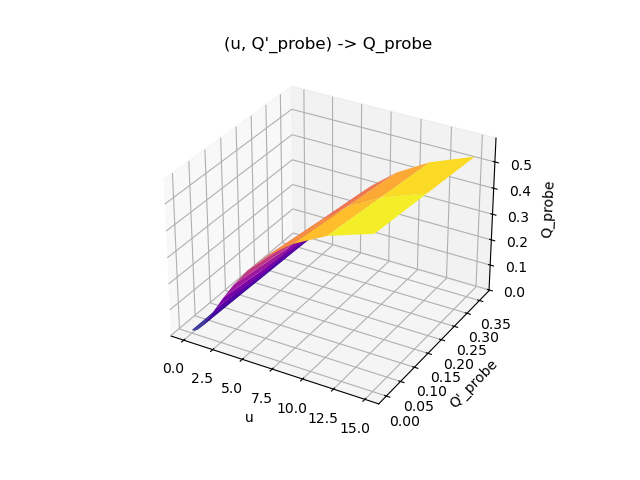

In [19]:
# VISUALISE THE RESULTS: (u, Qdash_probe) -> Q_probe
# create figure
u_Qdash_to_Q_fig = plt.figure(1)
plt.clf()
u_Qdash_to_Q_ax = u_Qdash_to_Q_fig.add_subplot(111, projection='3d')

# make a 3D plot of experimentally measured Q values
u_Qdash_to_Q_ax.plot_surface(
    us_mesh,
    Q_constrep_mesh,
    Q_probes,
    cmap=mpl.colormaps['plasma'],
    label='Measured Q values')

# format the plot
u_Qdash_to_Q_ax.set_title("(u, Q\'_probe) -> Q_probe")
u_Qdash_to_Q_ax.set_xlabel('u')
u_Qdash_to_Q_ax.set_ylabel('Q\'_probe')
u_Qdash_to_Q_ax.set_zlabel('Q_probe')

# show plot
plt.show()

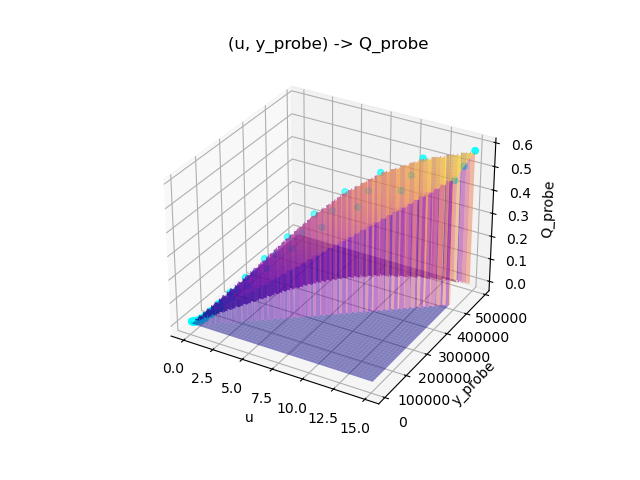

In [20]:
# VISUALISE THE RESULTS: (u, y_probe) -> Q_probe
# create figure
u_y_to_Q_fig = plt.figure(2)
plt.clf()
u_y_to_Q_ax = u_y_to_Q_fig.add_subplot(111, projection='3d')

# # make a 3D plot of experimentally measured Q values
u_y_to_Q_ax.scatter(
    us_mesh,
    y_probes,
    Q_probes,
    c='cyan', label='Measured Q values')

# make a 3D plot of estimated Q values
u_y_to_Q_ax.plot_surface(
    us_mesh_est,
    y_mesh_est,
    Q_est,
    cmap=mpl.colormaps['plasma'], alpha=0.5,
    label='Measured Q values')

# format the plot
u_y_to_Q_ax.set_title("(u, y_probe) -> Q_probe")
u_y_to_Q_ax.set_xlabel('u')
u_y_to_Q_ax.set_ylabel('y_probe')
u_y_to_Q_ax.set_zlabel('Q_probe')

# show plot
plt.show()

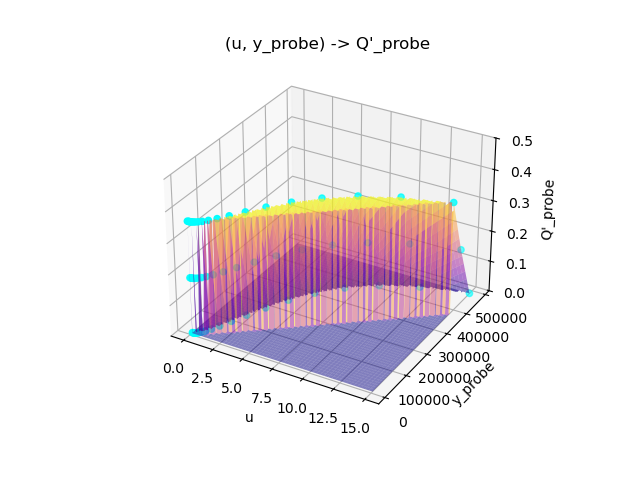

In [21]:
# VISUALISE THE RESULTS: (u, y_probe) -> Qdash_probe
# create figure
u_y_to_Qdash_fig = plt.figure(3)
plt.clf()
u_y_to_Qdash_ax = u_y_to_Qdash_fig.add_subplot(111, projection='3d')

# make a 3D plot of experimentally measured Q values
u_y_to_Qdash_ax.scatter(
    us_mesh,
    y_probes,
    Q_constrep_mesh,
    c='cyan', label='Measured Q values')
# make a 3D plot of experimentally measured Q values
u_y_to_Qdash_ax.plot_surface(
    us_mesh_est,
    y_mesh_est,
    Qdash_est,
    cmap=mpl.colormaps['plasma'], alpha=0.5,
    label='Estimated Q\' values')

# format the plot
u_y_to_Qdash_ax.set_title("(u, y_probe) -> Q\'_probe")
u_y_to_Qdash_ax.set_xlabel('u')
u_y_to_Qdash_ax.set_ylabel('y_probe')
u_y_to_Qdash_ax.set_zlabel('Q\'_probe')
u_y_to_Qdash_ax.set_zlim(0,0.5)

# show plot
plt.show()